### IMPORTS

In [5]:
import os
import sys
import time
import json
import queue
import threading
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import csv
from pyod.models.knn import KNN
import pandas as pd
from flask import Flask, jsonify
from werkzeug.routing import IntegerConverter
from _csv import Dialect as _Dialect
import csv

from rtls_util import RtlsUtil, RtlsUtilLoggingLevel, RtlsUtilException, RtlsUtilTimeoutException, \
    RtlsUtilNodesNotIdentifiedException, RtlsUtilScanNoResultsException
    
print(" Modules are successfully Initiated")

 Modules are successfully Initiated


### AoA DATA EXTRACTION

In [6]:
# PARAMETERS - SECONDS
data_collection_time = 30
slave_scan_time = 10
default_time = 30

# LIST FOR ACCUMULATE THE RESULTS
yy=[]

## User function to proces
def results_parsing(q):
    while True:
        try:
            data = q.get(block=True, timeout=0.5)
            if isinstance(data, dict):
                if data["name"] == "CC26x2 Master":
                    yy.append(data["payload"]["angle"])
            elif isinstance(data, str) and data == "STOP":
                print("STOP Command Received")
                break
            else:
                pass
        except queue.Empty:
            continue

## Main Function
def main():
    ## Predefined parameters
    slave_bd_addr = None  # "80:6F:B0:1E:38:C3" # "54:6C:0E:83:45:D8"
    scan_time_sec = slave_scan_time
    connect_interval_mSec = 180#100

    ## Continuous Connection Info Demo Enable / Disable
    cci = False
    ## Angle of Arival Demo Enable / Disable
    aoa = True
    ## Time of Flight Demo Enable / Disable
    tof = False
    tof_use_calibrate_from_nv = False
    ## Switch TOF Role Demo Enable / Disable
    tof_switch_role = False
    ## Update connection interval on the fly Demo Enable / Disable
    update_conn_interval = False
    new_connect_interval_mSec = 80

    ## Taking python file and replacing extension from py into log for output logs + adding data time stamp to file
    data_time = datetime.datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    logging_file_path = os.path.join(os.path.curdir, 'rtls_util_logs')
    if not os.path.isdir(logging_file_path):
        os.makedirs(logging_file_path)
    logging_file = os.path.join(logging_file_path, f"{data_time}_rtls_utils_logs")

    ## Initialize RTLS Util instance
    rtlsUtil = RtlsUtil(logging_file, RtlsUtilLoggingLevel.INFO)
    ## Update general time out for all action at RTLS Util [Default timeout : 30 sec]
    rtlsUtil.timeout = default_time

    all_nodes = []
    try:
        devices = [
            # {"com_port": "COM7", "baud_rate": 460800, "name": "CC26x2 Master"},
            # {"com_port": "COM6", "baud_rate": 460800, "name": "CC26x2 Passive"},
            {"com_port": "COM3", "baud_rate": 460800, "name": "CC26x2 Master"},
            # {"com_port": "COM23", "baud_rate": 460800, "name": "CC2640r2 TOF Master"},
            # {"com_port": "COM21", "baud_rate": 460800, "name": "CC2640r2 TOF Passive"}
        ]
        ## Setup devices
        master_node, passive_nodes, all_nodes = rtlsUtil.set_devices(devices)
        print(f"Master : {master_node} \nPassives : {passive_nodes} \nAll : {all_nodes}")

        ## Reset devices for initial state of devices
        rtlsUtil.reset_devices()
        print("Devices Reset")

        ## Code below demonstrates two option of scan and connect
        ## 1. Then user know which slave to connect
        ## 2. Then user doesn't mind witch slave to use
        if slave_bd_addr is not None:
            print(f"Start scan of {slave_bd_addr} for {scan_time_sec} sec")
            scan_results = rtlsUtil.scan(scan_time_sec, slave_bd_addr)
            print(f"Scan Results: {scan_results}")

            rtlsUtil.ble_connect(slave_bd_addr, connect_interval_mSec)
            print("Connection Success")
        else:
            print(f"Start scan for {scan_time_sec} sec")
            scan_results = rtlsUtil.scan(scan_time_sec)
            print(f"Scan Results: {scan_results}")

            rtlsUtil.ble_connect(scan_results[0], connect_interval_mSec)
            print("Connection Success")

        ## Start continues connection info feature
        if cci:
            if rtlsUtil.is_tof_supported(all_nodes):
                ## Setup thread to pull out received data from devices on screen
                th_cci_parsing = threading.Thread(target=results_parsing, args=(rtlsUtil.conn_info_queue,))
                th_cci_parsing.setDaemon(True)
                th_cci_parsing.start()
                print("CCI Callback Set")

                rtlsUtil.cci_start()
                print("CCI Started")
            else:
                print("=== Warning ! One of the devices does not support CCI functionality ===")

        ## Start angle of arrival feature
        if aoa:
            if rtlsUtil.is_aoa_supported(all_nodes):
                aoa_params = {
                    "aoa_run_mode": "AOA_MODE_ANGLE",  ## AOA_MODE_ANGLE, AOA_MODE_PAIR_ANGLES, AOA_MODE_RAW
                    "aoa_cc2640r2": {
                        "aoa_cte_scan_ovs": 4,
                        "aoa_cte_offset": 4,
                        "aoa_cte_length": 20,
                        "aoa_sampling_control": int('0x00', 16),
                        ## bit 0   - 0x00 - default filtering, 0x01 - RAW_RF no filtering - not supported,
                        ## bit 4,5 - 0x00 - default both antennas, 0x10 - ONLY_ANT_1, 0x20 - ONLY_ANT_2
                    },
                    "aoa_cc26x2": {
                        "aoa_slot_durations": 1,
                        "aoa_sample_rate": 1,
                        "aoa_sample_size": 1,
                        "aoa_sampling_control": int('0x10', 16),
                        ## bit 0   - 0x00 - default filtering, 0x01 - RAW_RF no filtering,
                        ## bit 4,5 - default: 0x10 - ONLY_ANT_1, optional: 0x20 - ONLY_ANT_2
                        "aoa_sampling_enable": 1,
                        "aoa_pattern_len": 3,
                        "aoa_ant_pattern": [0, 1, 2]
                    }
                }
                rtlsUtil.aoa_set_params(aoa_params)
                print("AOA Params Set")

                ## Setup thread to pull out received data from devices on screen
                th_aoa_results_parsing = threading.Thread(target=results_parsing, args=(rtlsUtil.aoa_results_queue,))
                th_aoa_results_parsing.setDaemon(True)
                th_aoa_results_parsing.start()
                print("AOA Callback Set")

                rtlsUtil.aoa_start(cte_length=20, cte_interval=1)
                print("AOA Started")
            else:
                print("=== Warning ! One of the devices does not support AoA functionality ===")

        ## Start time of flight feature
        if tof:
            if rtlsUtil.is_tof_supported(all_nodes):
                tof_params = {
                "tof_sample_mode": "TOF_MODE_DIST",  ## TOF_MODE_DIST, TOF_MODE_STAT, TOF_MODE_RAW
                "tof_run_mode": "TOF_MODE_CONT",
                "tof_slave_lqi_filter": 25,
                "tof_post_process_lqi_thresh": 20,
                "tof_post_process_magn_ratio": 111,
                "tof_samples_per_burst": 256,
                "tof_freq_list": [2416, 2418, 2420, 2424, 2430, 2432, 2436, 2438],
                "tof_auto_rssi": -55,
                }
                rtlsUtil.tof_set_params(tof_params)
                print("TOF Paramas + Seed Set")

                ## Code below demonstrate option where the user doesn't want to use internal calibration
                if tof_params['tof_sample_mode'] == "TOF_MODE_DIST":
                    rtlsUtil.tof_calibrate(samples_per_freq=1024, distance=1, use_nv_calib=tof_use_calibrate_from_nv)
                    print("Calibration Done")

                    # print(json.dumps(rtlsUtil.tof_get_calib_info(), indent=4))
                    # print("Calibration Info Done")

                ## Setup thread to pull out received data from devices on screen
                th_tof_results_parsing = threading.Thread(target=results_parsing, args=(rtlsUtil.tof_results_queue,))
                th_tof_results_parsing.setDaemon(True)
                th_tof_results_parsing.start()
                print("TOF Callback Set")

                rtlsUtil.tof_start()
                print("TOF Started")

                ## Start switch role feature while TOF is running
                if tof_switch_role and len(passive_nodes) > 0:
                    time.sleep(2)
                    print("Slept for 2 sec before switching roles")

                    rtlsUtil.tof_stop()
                    print("TOF Stopped")

                    master_capab = rtlsUtil.get_devices_capability(nodes=[master_node])[0]
                    print(f"RTLS MASTER capability before role switch: {json.dumps(master_capab, indent=4)}")

                    rtlsUtil.tof_role_switch(tof_master_node=master_node, tof_passive_node=passive_nodes[0])
                    print("TOF Role Switch Done")

                    master_capab = rtlsUtil.get_devices_capability(nodes=[master_node])[0]
                    print(f"RTLS MASTER capability after role switch: {json.dumps(master_capab, indent=4)}")

                    rtlsUtil.tof_calibrate(samples_per_freq=1000, distance=1)
                    print("Calibration Done")

                    rtlsUtil.tof_start()
                    print("TOF Re-Started")
            else:
                print("=== Warring ! One of the devices does not support ToF functionality ===")

        ## Update connection interval after connection is set
        if update_conn_interval:
            time.sleep(2)
            print("Sleep for 2 sec before update connection interval")

            rtlsUtil.set_connection_interval(new_connect_interval_mSec)
            print(f"Update Connection Interval into : {new_connect_interval_mSec} mSec")

        ## Sleep code to see in the screen receives data from devices
        timeout_sec = data_collection_time
        print("Going to sleep for {} sec".format(timeout_sec))
        timeout = time.time() + timeout_sec
        while timeout >= time.time():
            time.sleep(0.01)

    except RtlsUtilNodesNotIdentifiedException as ex:
        print(f"=== ERROR: {ex} ===")
        print(ex.not_indentified_nodes)
    except RtlsUtilTimeoutException as ex:
        print(f"=== ERROR: {ex} ===")
    except RtlsUtilException as ex:
        print(f"=== ERROR: {ex} ===")
    finally:
        if cci and rtlsUtil.is_tof_supported(all_nodes):
            rtlsUtil.conn_info_queue.put("STOP")
            print("Try to stop CCI result parsing thread")

            rtlsUtil.cci_stop()
            print("CCI Stopped")

        if aoa and rtlsUtil.is_aoa_supported(all_nodes):
            rtlsUtil.aoa_results_queue.put("STOP")
            print("Try to stop AOA result parsing thread")

            rtlsUtil.aoa_stop()
            print("AOA Stopped")

        if tof and rtlsUtil.is_tof_supported(all_nodes):
            rtlsUtil.tof_results_queue.put("STOP")
            print("Try to stop TOF result parsing thread")

            rtlsUtil.tof_stop()
            print("TOF Stopped")

        if rtlsUtil.ble_connected:
            rtlsUtil.ble_disconnect()
            print("Master Disconnected")

        rtlsUtil.done()
        print("Done")

        rtlsUtil = None


    return sort_list()


def sort_list():
    y = yy.copy()

    yy.clear()
    # Train a kNN detector
    clf_name = 'kNN'
    clf = KNN()  # Initialize Detector clf
    clf.fit(np.array(y).reshape(-1, 1))  # Use X_train to train the detector clf
    # Returns the abnormal labels and abnormal scores on the traning data X_train
    y_train_pred = clf.labels_  #  Returs the Classification Labels on the Training Data(0: Normal Value, 1: Outlier)
    # y_train_scores = clf.decision_scores_  # Return the abnormal Value on the Training Data(The larger the Score, the More Abnormal)
    result = []
    for i, k in enumerate(y):
        if y_train_pred[i] == 0:
            result.append(k)
    Percentile = np.percentile(result, [50], axis=0)
    return result

# TEST

In [7]:
# FILE NAME HANDLING
def create_file_name(environment,distance,angle):
    return environment+'_' + str(distance)+'_'+ str(angle)

***DATA COLLECTION***

In [8]:
# SPECIFYING PARAMETERS
angle = 0                       #degrees
distance = 50                  #cm
environment = 'indoor'
results_dir = './results_npz/'
result_file = environment+'_'+str(distance)+'_'+str(angle)
slave_scan_time = 5
default_time = 30
data_collection_time = 20

# Collecting Data
yy=[]
calculated_angles = np.array(main())
np.save(results_dir+create_file_name(environment,distance,angle),calculated_angles)

print("DATA COLLECTION SUCCESS")
print("# OF COLLECTED SAMPLES:",len(calculated_angles))

Master : <RTLSNode(CC26x2 Master, started 4464)> 
Passives : [] 
All : [<RTLSNode(CC26x2 Master, started 4464)>]
Devices Reset
Start scan for 5 sec
Scan Results: [{'addr': '80:6F:B0:EE:9C:67', 'addrType': 0, 'rssi': -62, 'advSID': 255, 'periodicAdvInt': 0}]
Connection Success
AOA Params Set
AOA Callback Set
AOA Started
Going to sleep for 20 sec
Try to stop AOA result parsing threadSTOP Command Received

AOA Stopped
Master Disconnected
Done
DATA COLLECTION SUCCESS
# OF COLLECTED SAMPLES: 53


### ***TEST-I***: **AoA Data Spread**

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

# FILE NAME HANDLING
def get_files(DIRECTORY):
    filenames = os.listdir(DIRECTORY)
    return [filename.split('.')[0] for filename in filenames]


def extract_data(FILE_NAME): 
    environment, distance, angle = FILE_NAME.split('_')
    return environment,int(distance),int(angle)

C:\Users\sanji\AppData\Local\Temp\ipykernel_18636\1274827063.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(angles_radian, distances,s=size, c=colors,marker=marker_style,label="%dcm"%distance)


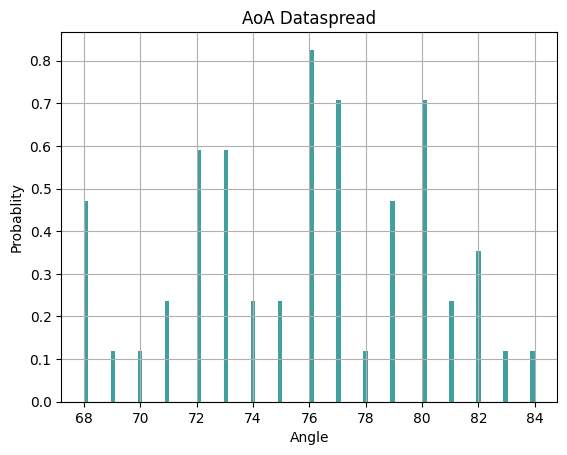

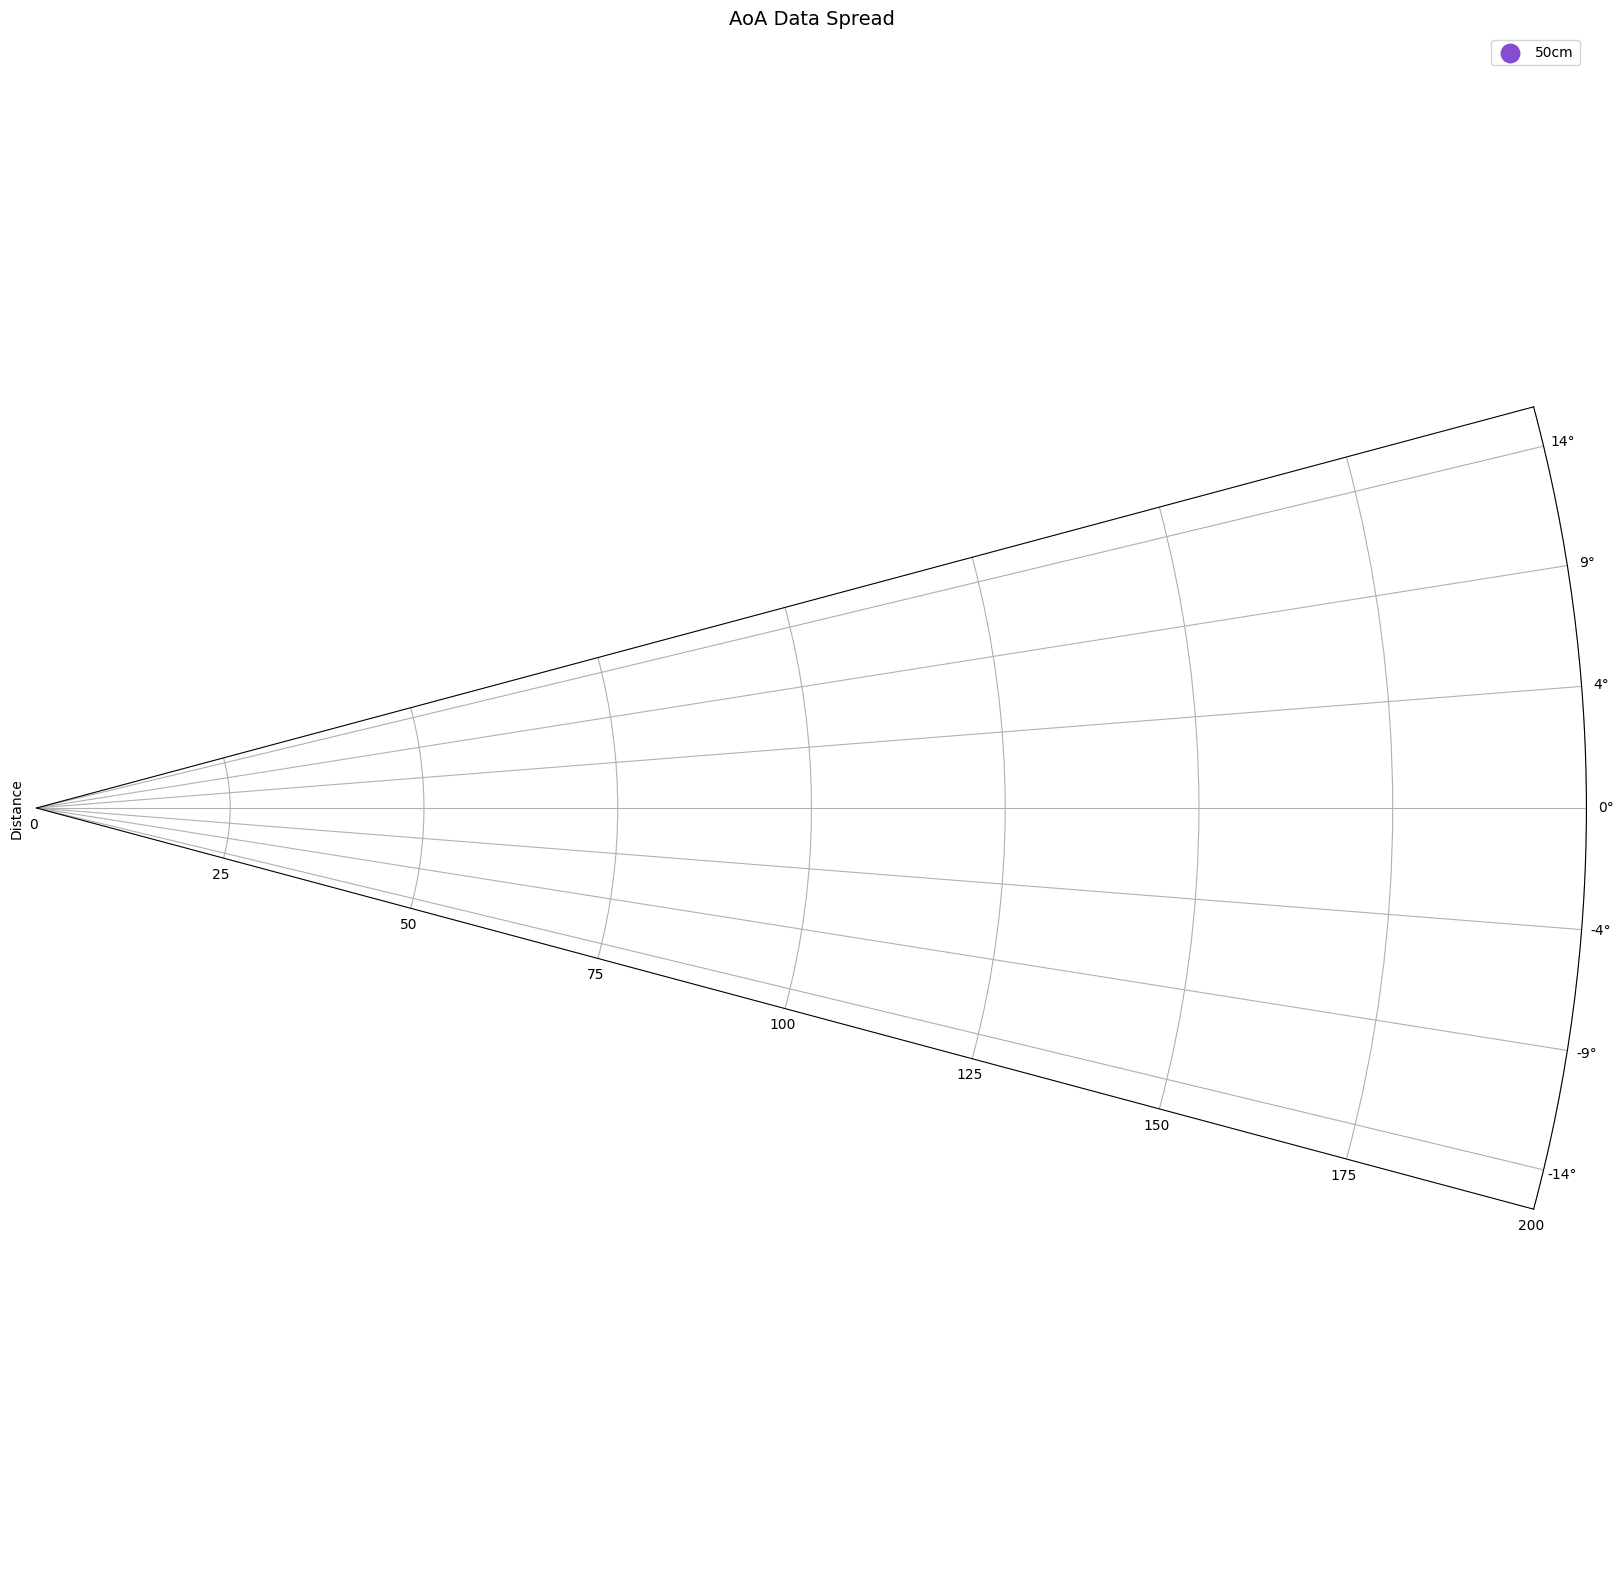

In [11]:
data_dir = './results_npz/'
results_dir = './results_images/'
interested_environment = 'indoor'
hist_bins = 100
polar_bins = 10

# HISTOGRAM
for file_name in get_files(data_dir):
    environment, distance, angle = extract_data(file_name)
    if environment==interested_environment and angle==0:
        calculated_angles = np.load(data_dir+file_name+'.npy')

        
        n, bins, patches = plt.hist(calculated_angles, hist_bins, density=True, facecolor='teal', alpha=.75)
        plt.xlabel('Angle')
        plt.ylabel('Probablity')
        plt.title('AoA Dataspread')
        plt.grid(True)
        plt.savefig(results_dir+file_name+'_hist')

# CREATE A POLAR SCATTER PLOT
fig = plt.figure(figsize=(20,32))
ax = fig.add_subplot(111, projection='polar')

for file_name in get_files(data_dir):
    environment, distance, angle = extract_data(file_name)
    if environment==interested_environment and angle==0:
        calculated_angles = np.load(data_dir+file_name+'.npy')

        freqs, angles = np.histogram(calculated_angles,polar_bins,density=True)
        angles_radian = np.radians(angles[1:])



        # ATTRIBUTES
        distances = distance*np.ones(polar_bins)
        colors = np.random.rand(3)
        marker_style = 'o'
        size = freqs * 2000

        # PLOTTING THE POINTS
        ax.scatter(angles_radian, distances,s=size, c=colors,marker=marker_style,label="%dcm"%distance)


ax.set_ylim([0, 200])
ax.set_thetamin(-15)
ax.set_thetamax(15)
ax.set_title('AoA Data Spread', fontsize=14)
ax.set_ylabel("Distance")
plt.legend(loc="upper right")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(results_dir+interested_environment+'_0_'+'_polar')


### ***TEST-II***: **RELATIVE ACCURACY**

C:\Users\sanji\AppData\Local\Temp\ipykernel_18636\2836662630.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(angles_radian, distances,s=size, c=colors,marker=marker_style,label="%.2f degree"%angle)


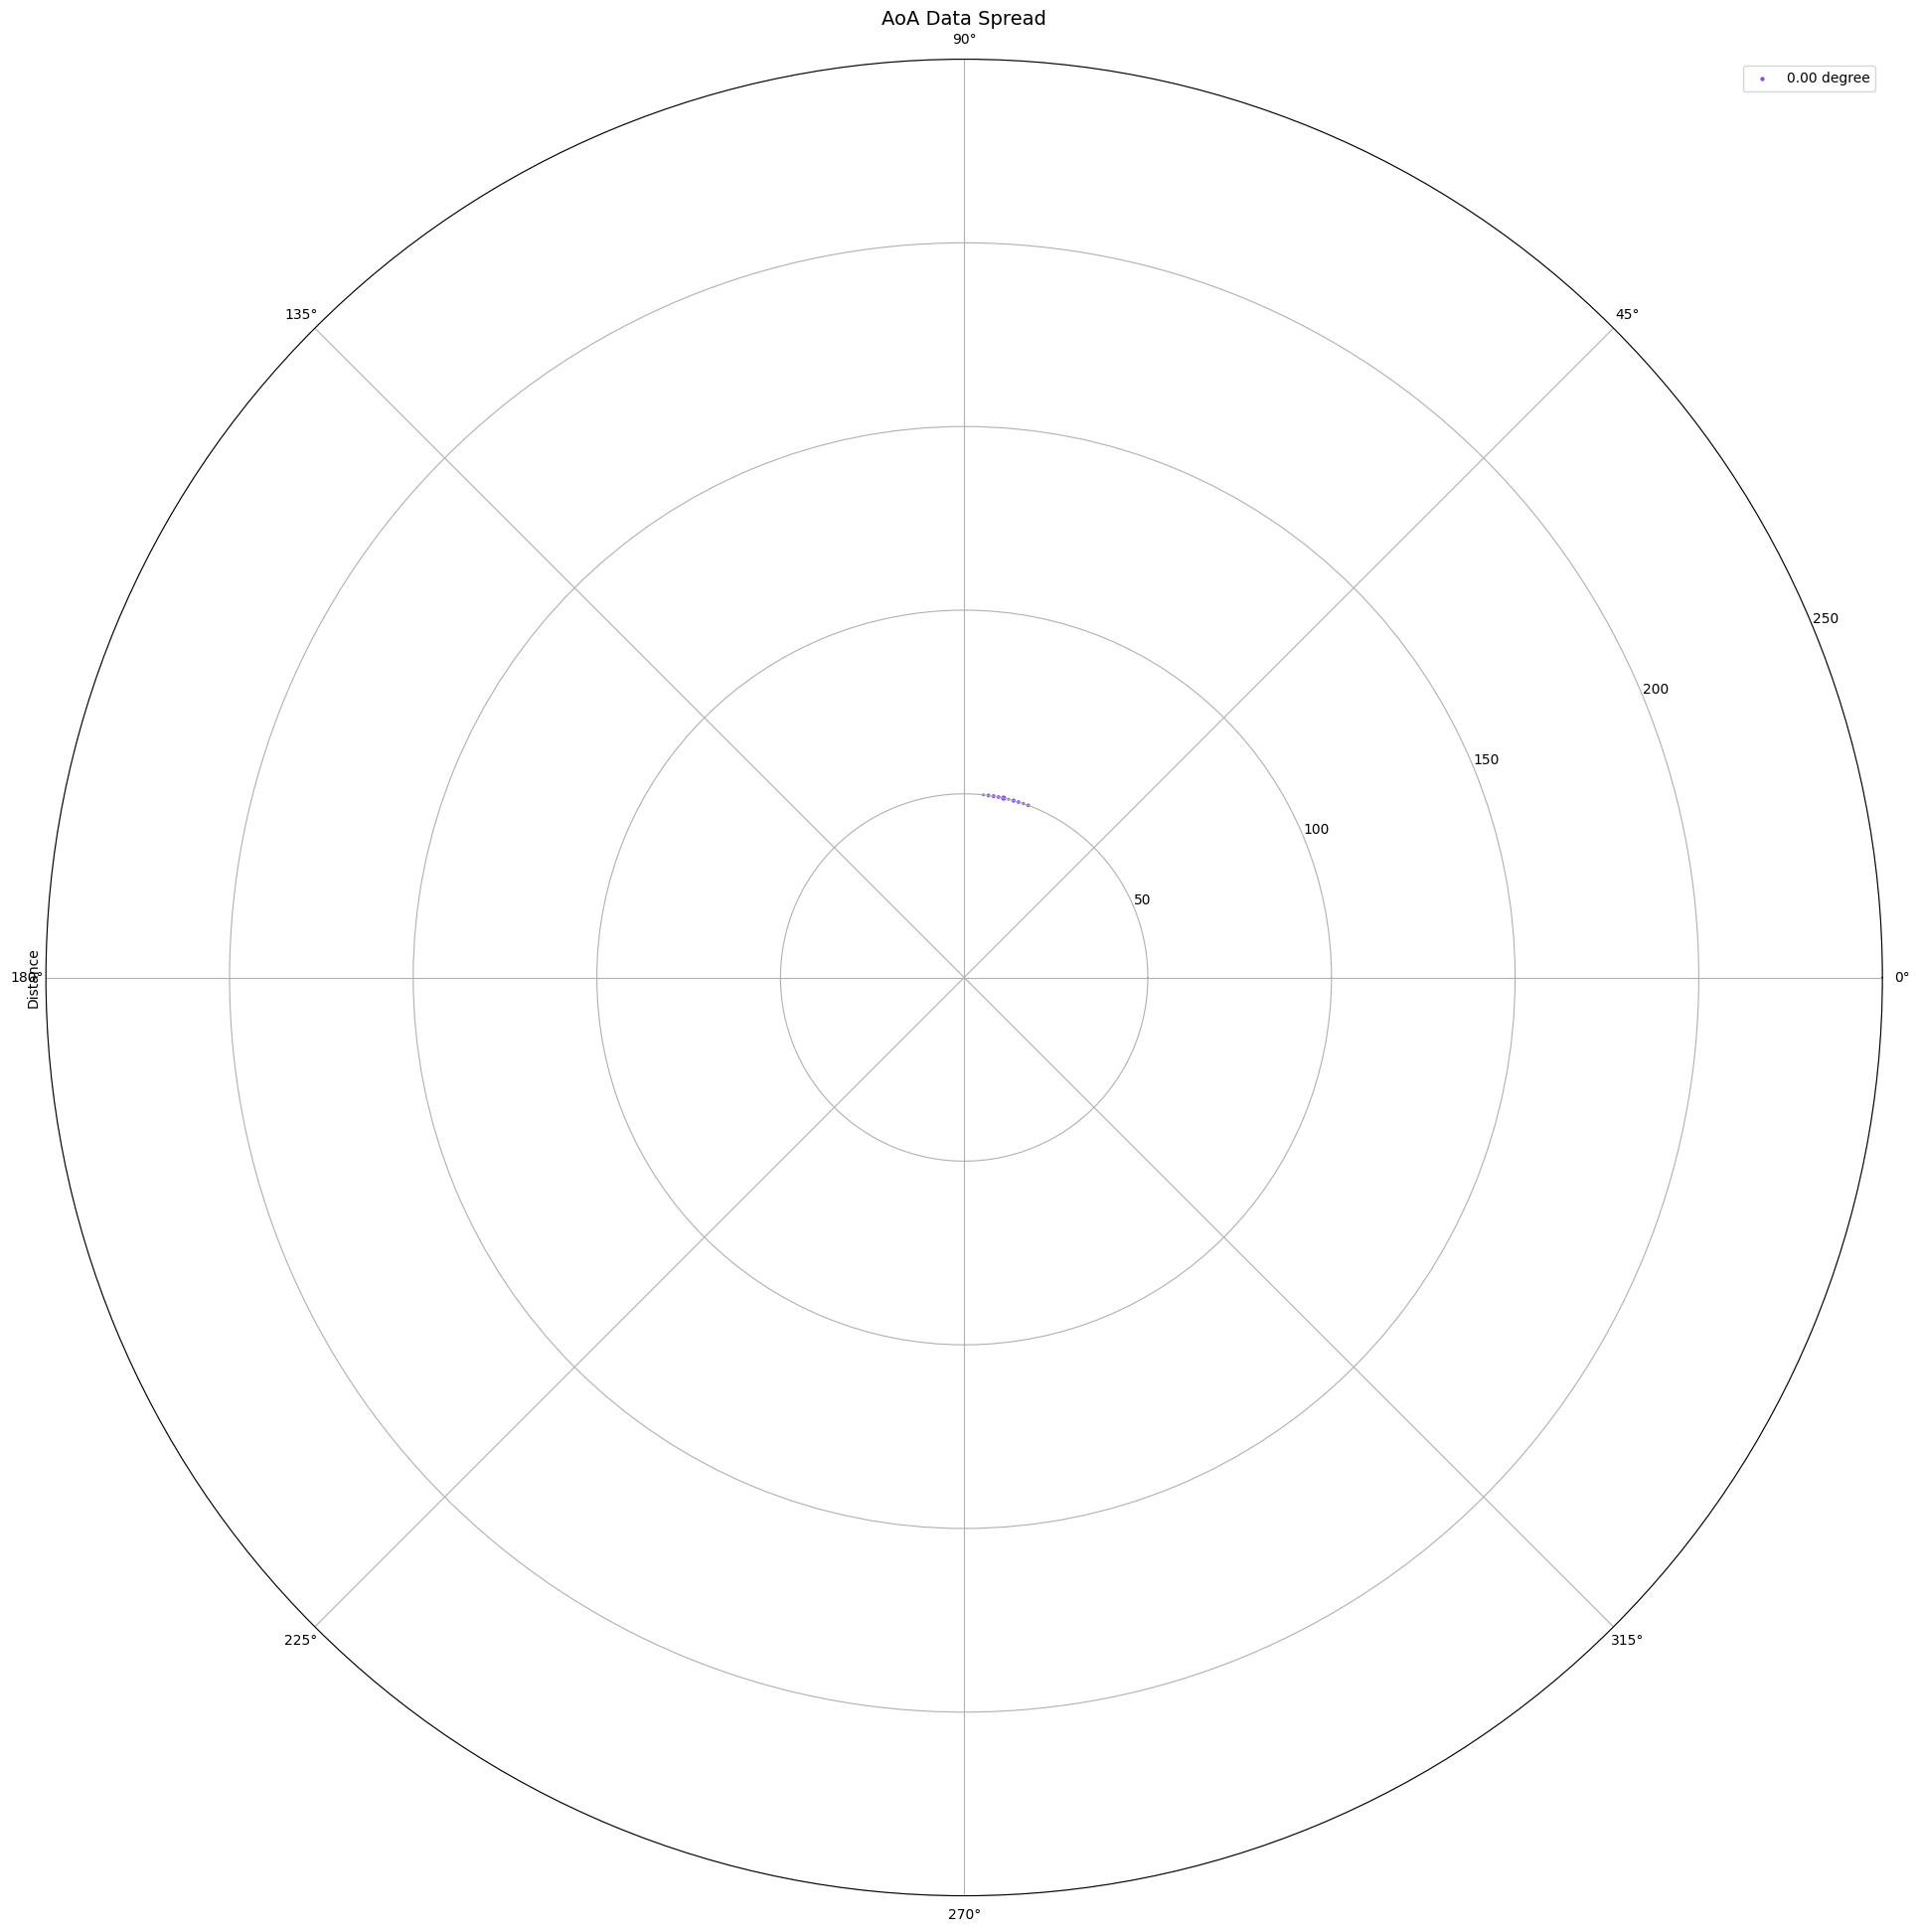

In [12]:
# VISUALIZING THE DATA
data_dir = './results_npz/'
results_dir = './results_images/'

# CREATE A POLAR SCATTER PLOT
fig = plt.figure(figsize=(32,24))
ax = fig.add_subplot(111, projection='polar')

for file_name in get_files(data_dir):
    environment, distance, angle = extract_data(file_name)
    if environment == 'indoor':
        calculated_angles = np.load(data_dir+file_name+'.npy')

        freqs, angles = np.histogram(calculated_angles,polar_bins,density=True)
        angles_radian = np.radians(angles[1:])

        # ATTRIBUTES
        distances = distance*np.ones(polar_bins)
        colors = np.random.rand(3)
        marker_style = 'o'
        size = freqs * distance 

        # PLOTTING THE POINTS
        ax.scatter(angles_radian, distances,s=size, c=colors,marker=marker_style,label="%.2f degree"%angle)

# Set the limit for the radial axis
ax.set_ylim([0, 250])
# Add a title to the plot
ax.set_title('AoA Data Spread', fontsize=14)
ax.set_ylabel("Distance")
plt.legend(loc="upper right")
# Show the plot
plt.savefig(results_dir+environment)
plt.show()